# Test the filter time for binary files in azimuth, height, distance format

In [2]:
import numba
from numba import njit, prange
import os
import random
import sys
import time
import numpy as np
import pandas as pd
from pathlib import Path
from contextlib import redirect_stdout
from mmdet3d.apis import LidarDet3DInferencer

## May need to change back the lon values in the numba library

In [3]:
# Initialize inferencer
inferencer = LidarDet3DInferencer('pointpillars_kitti-3class')

/home/rachel/mmdetection3d/mmdet3d/models/dense_heads/anchor3d_head.py:94: UserWarning: dir_offset and dir_limit_offset will be depressed and be incorporated into box coder in the future
  warnings.warn(


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmdetection3d/v1.0.0_models/pointpillars/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class/hv_pointpillars_secfpn_6x8_160e_kitti-3d-3class_20220301_150306-37dc2420.pth
12/20 22:57:36 - mmengine - WARNING - Failed to search registry with scope "mmdet3d" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet3d" is a correct scope, or whether the registry is initialized.
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/rachel/miniconda3/envs/openmm_mmvc/lib/python3.8/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


In [4]:
azimuth_resolution = 0.1
elevation_resolution = 0.25

In [5]:
def convert_to_dataframe(bin_path):
    pre_filtered_data = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 5) 
    columns = ['x', 'y', 'z', 'intensity', 'elevation']
    df = pd.DataFrame(pre_filtered_data, columns=columns)
    return df

In [6]:
# Returns list of dataframes of LiDAR points
def get_frames(source_dir, num_frames):
    frame_list = []
    
    # Get frame names
    files = [f for f in os.listdir(source_dir) if f.endswith('.bin')]
    # Shuffle and take desired number of files
    random.shuffle(files)
    files = files[:num_frames]
    
    # For each frame
    for file in files:
        print('.', end='')
        file_path = Path(source_dir, file)
        # Load each frame
        df = convert_to_dataframe(file_path)
        # Incoming lidar packets won't have azimuth angle, so drop it to time calculation
        
        frame_list.append(df)
        
    return frame_list

In [7]:
# Unpickle background map dataframe and fill the empty values
def get_filter(background_map_path):
    background_distance_lookup_table = pd.read_pickle(background_map_path)
    filled_lookup_table = background_distance_lookup_table.ffill(axis=0).bfill(axis=0)
    filled_lookup_table = filled_lookup_table.ffill(axis=1).bfill(axis=1)
    return filled_lookup_table

In [8]:
def add_lookup_coords_to_xyz(points_df):
    # print(points_df)
    # Calculate the distance, azimuth, and height using vectorized operations
    x, y, z, elevation = points_df['x'], points_df['y'], points_df['z'], points_df['elevation']
    
    azimuth = np.degrees(np.arctan2(y, x))
    
    # Convert and scale
    azimuth_idx = (np.floor((azimuth + 180) / azimuth_resolution) * azimuth_resolution * 10 - 1800).astype(int)
    height_idx = (np.floor((elevation + 30) / elevation_resolution) * elevation_resolution * 10 - 300).astype(int)

    points_df['azimuth_idx'] = azimuth_idx
    points_df['height_idx'] = height_idx
    # This would be roughly height angle / 55
    points_df['delta_z'] = elevation / 55
    
    return points_df

In [9]:
def filter_frame(frame_df, lookup_table):
    pre_filtered_grid_lookup = add_lookup_coords_to_xyz(frame_df)
    
    # Convert 'azimuth_idx' and 'height_idx' to integers
    pre_filtered_grid_lookup['azimuth_idx'] = pre_filtered_grid_lookup['azimuth_idx'].astype(int)
    pre_filtered_grid_lookup['height_idx'] = pre_filtered_grid_lookup['height_idx'].astype(int)

    # Set index to ['height_idx', 'azimuth_idx'] for alignment with lookup_table
    pre_filtered_grid_lookup.set_index(['height_idx', 'azimuth_idx'], inplace=True)
    
    # Flatten the lookup_table into a series with MultiIndex from its row and column indices
    lookup_series = lookup_table.stack()

    # Reindex the lookup values to align with the pre_filtered_grid_lookup index
    lookup_values = lookup_series.reindex(pre_filtered_grid_lookup.index)

    # Compute effective heights and absolute comparison within the DataFrame
    pre_filtered_grid_lookup['effective_height'] = abs(pre_filtered_grid_lookup['z'] + pre_filtered_grid_lookup['delta_z'])
    pre_filtered_grid_lookup['bg_height'] = lookup_values

    # Filter based on condition: check where effective height is less than the background height
    filtered_df = pre_filtered_grid_lookup[pre_filtered_grid_lookup['effective_height'] < abs(pre_filtered_grid_lookup['bg_height'])]

    # Reset index if you want 'height_idx' and 'azimuth_idx' as columns
    filtered_df = filtered_df.reset_index()

    return filtered_df

In [10]:
def convert_to_xyz(points_df):
    x, y, z, intensity = points_df['x'], points_df['y'], points_df['z'], points_df['intensity']
    
    # Stack the computed values into a numpy array
    xyz_intensity_array = np.column_stack((x, y, z, intensity))
    
    return xyz_intensity_array

In [11]:
def time_filter(lidar_frames_list, filter_df, filter_points=True):
    # Start timer
    start = time.time()
    # For each frame
    for frame_df in lidar_frames_list:
        # Filter frame
        if filter_points:
            frame_df = filter_frame(frame_df, filter_df)
        # Convert to x, y, z
        xyz_frame = convert_to_xyz(frame_df)
        
        # Run Inferences
        inferencer(dict(points=xyz_frame))
    # Stop timer
    end = time.time()
    return end - start

In [12]:
def run_test(data_dir, background_map_path, num_frames):
    # Get dataframes
    lidar_frames_list = get_frames(data_dir, num_frames)
    filter_df = get_filter(background_map_path)
    print(lidar_frames_list[0])
    
    total_time_filter = time_filter(lidar_frames_list, filter_df)
    
    total_time_no_filter = time_filter(lidar_frames_list, pd.DataFrame(), filter_points=False)
    
    results_filter = {
        'type': 'filtered',
        'num_frames': num_frames,
        'total_time': total_time_filter,
        'time_per_frame': total_time_filter / num_frames
    }
    
    results_no_filter = {
        'type': 'not filtered',
        'num_frames': num_frames,
        'total_time': total_time_no_filter,
        'time_per_frame': total_time_no_filter / num_frames
    }
    return [results_filter, results_no_filter]

In [13]:
data_dir = '../data/elevation_height_points'
background_map_path = '../data/height_lookup_table.pkl'

In [14]:
%%capture
# Run time test and get results
time_results = run_test(data_dir, background_map_path, 10)

In [15]:
results_df = pd.DataFrame(time_results)
display(results_df)

,type,num_frames,total_time,time_per_frame
0,filtered,10,2.810081,0.281008
1,not filtered,10,0.919637,0.091964


In [16]:
# Filter one frame to check
test_frame_path = Path(data_dir, '000004.bin')
test_df = convert_to_dataframe(test_frame_path)
# test_df.drop(['azimuth'], axis=1, inplace=True)
test_filter = get_filter(background_map_path)
filtered_frame = filter_frame(test_df, test_filter)

In [17]:
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

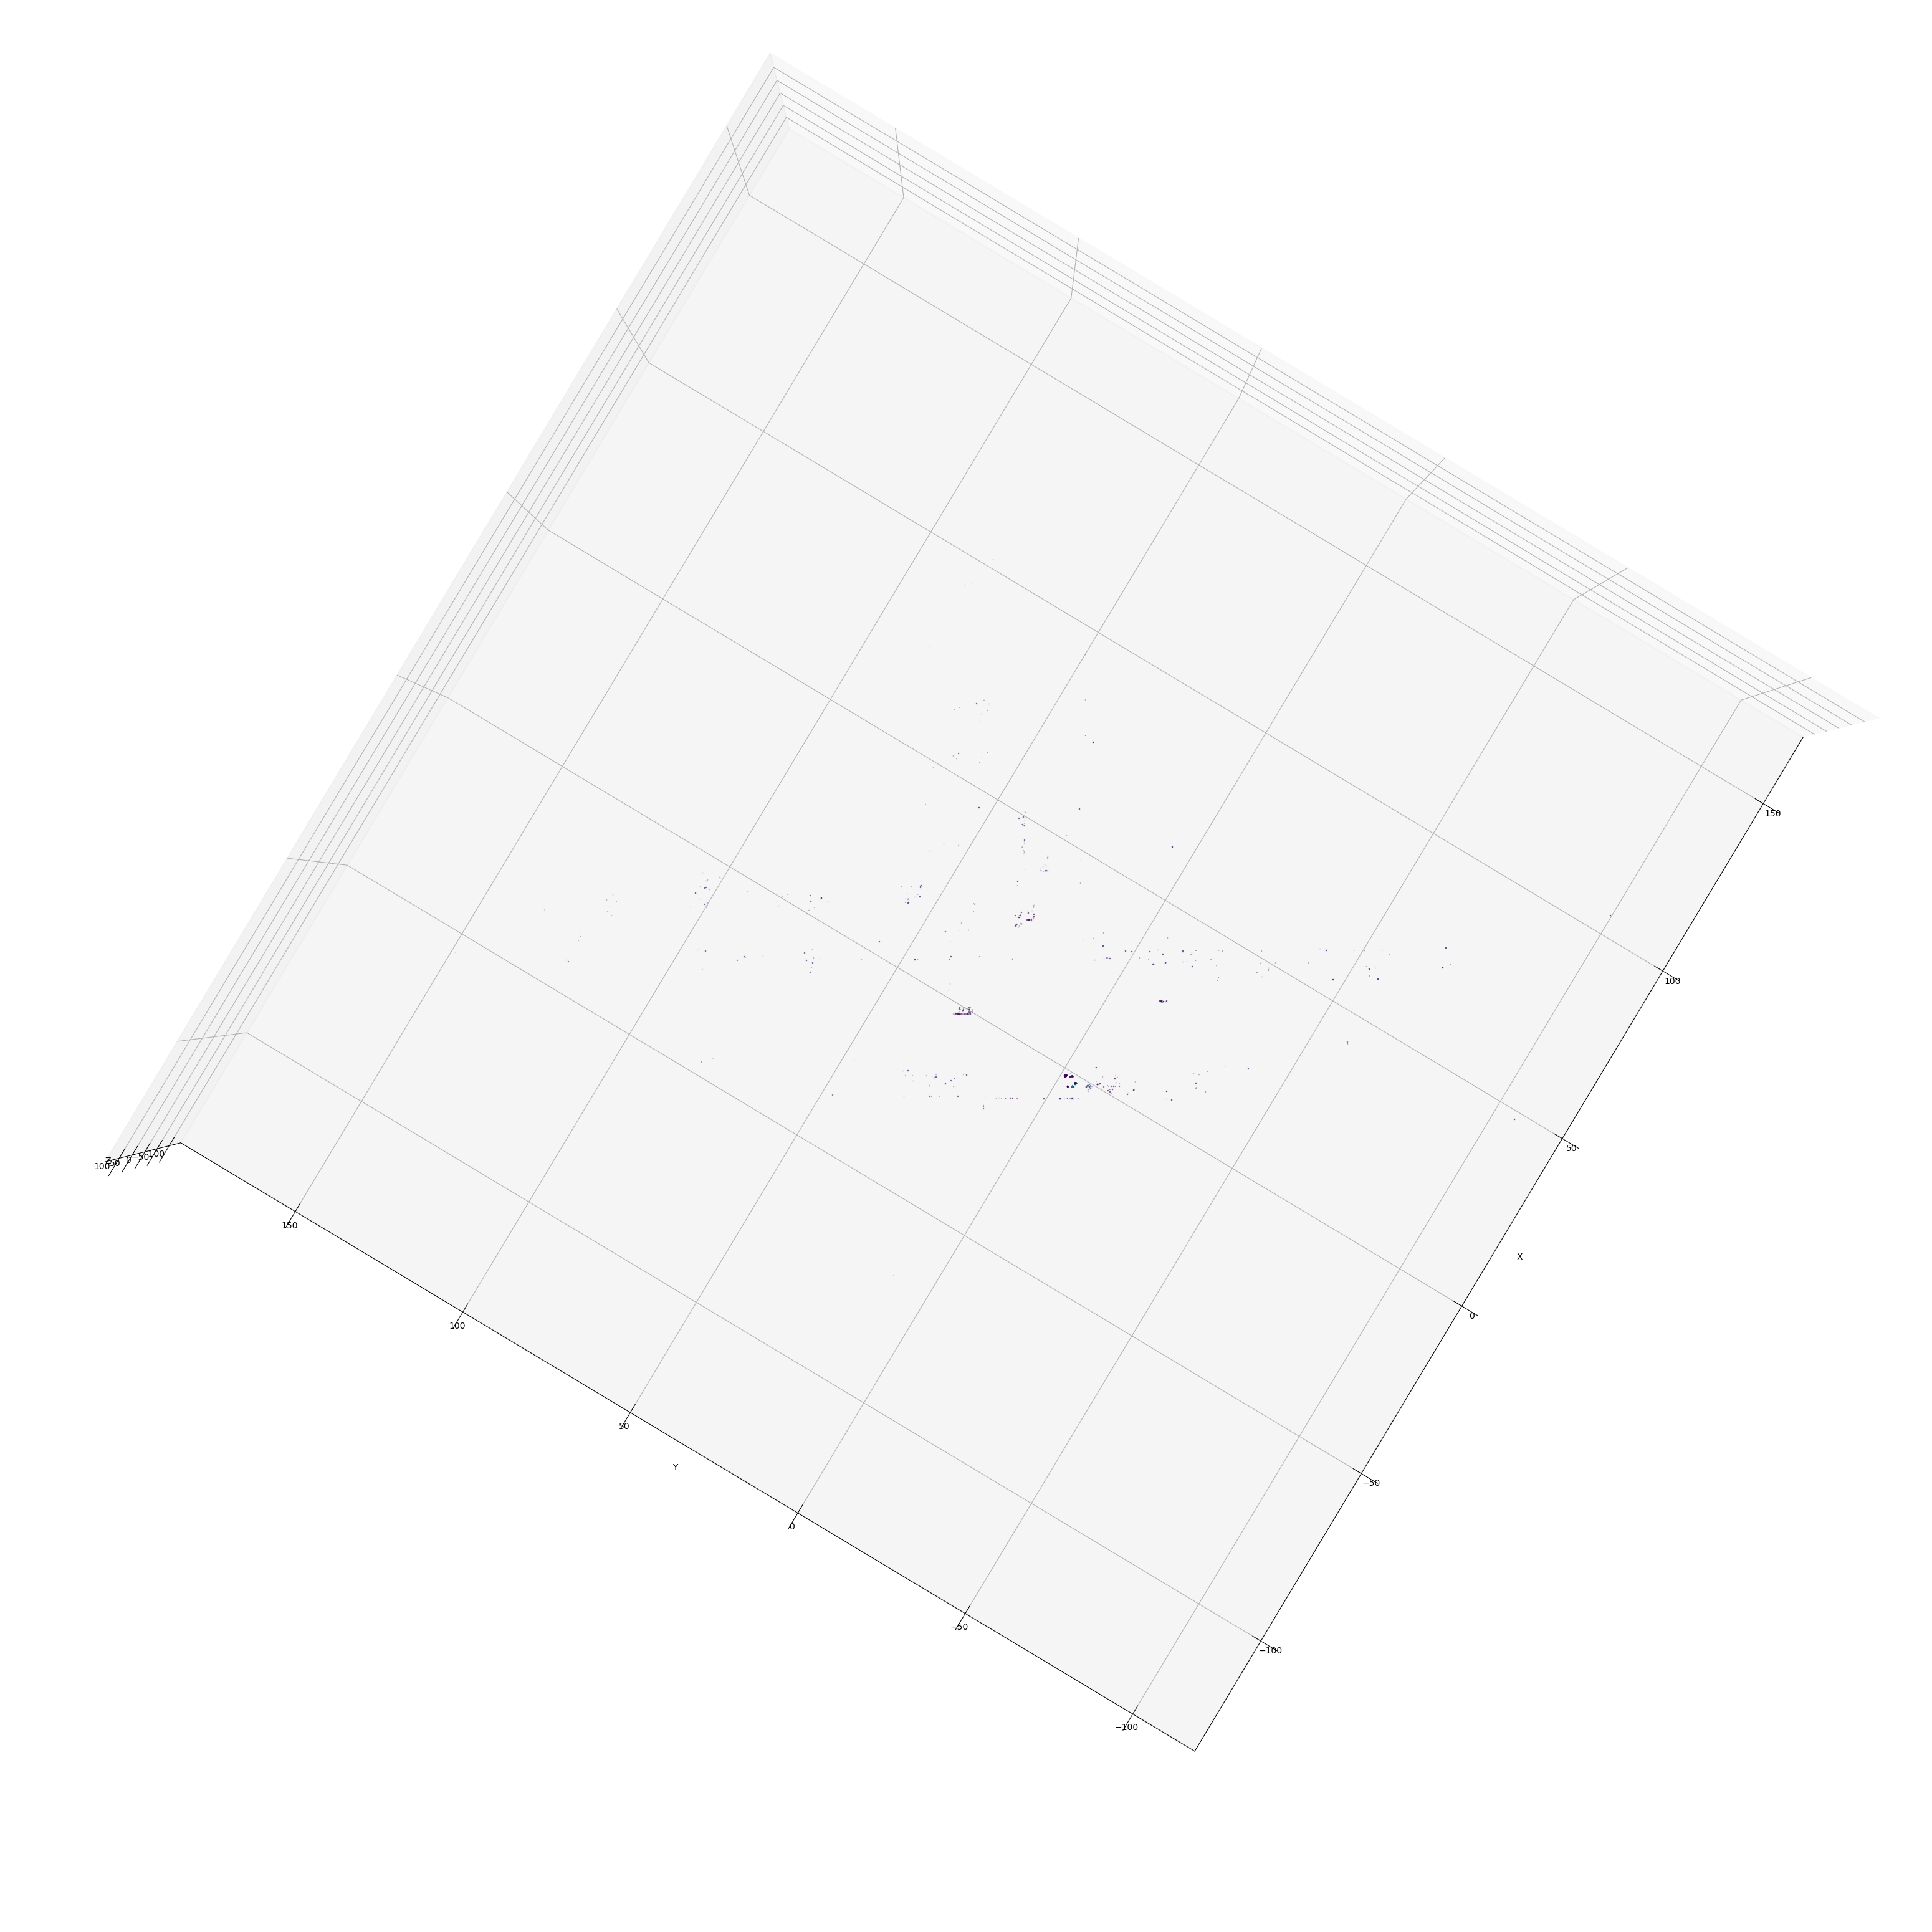

In [18]:
import matplotlib.pyplot as plt
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(filtered_frame['x'], filtered_frame['y'], filtered_frame['z'], s=0.1, c=filtered_frame['intensity'], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()

# Numba versions of functions

In [19]:
def convert_to_np_array(bin_path):
    pre_filtered_data = np.fromfile(bin_path, dtype=np.float32).reshape(-1, 5) 
    return pre_filtered_data

In [20]:
# Returns list of frames of LiDAR points
def get_frames(source_dir, num_frames):
    frame_list = []
    
    # Get frame names
    files = [f for f in os.listdir(source_dir) if f.endswith('.bin')]
    # Shuffle and take desired number of files
    random.shuffle(files)
    files = files[:num_frames]
    
    # For each frame
    for file in files:
        print('.', end='')
        file_path = Path(source_dir, file)
        
        # Load each frame
        np_array = convert_to_np_array(file_path)
        # Incoming lidar packets won't have azimuth angle, so drop it to time calculation
        
        frame_list.append(np_array)
        
    return frame_list

In [21]:
# Unpickle background map dataframe and fill the empty values
def get_filter(background_map_path):
    background_distance_lookup_table = pd.read_pickle(background_map_path)
    filled_lookup_table = background_distance_lookup_table.ffill(axis=0).bfill(axis=0)
    filled_lookup_table = filled_lookup_table.ffill(axis=1).bfill(axis=1)
    return filled_lookup_table

In [22]:
@njit
def compute_lookup_coords(x, y, elevation):
    azimuth = np.degrees(np.arctan2(y, x))
    
    azimuth_idx = np.floor((azimuth + 180) / azimuth_resolution) * azimuth_resolution * 10 - 1800
    elevation_idx = np.floor((elevation + 30) / elevation_resolution) * elevation_resolution * 10 - 300

    azimuth_idx = azimuth_idx.astype(np.int32)
    elevation_idx = elevation_idx.astype(np.int32)
    
    delta_z = elevation / 55

    return azimuth_idx, elevation_idx, delta_z

In [23]:
def add_lookup_coords_to_ahd(np_frame):
    # Extract columns from np_frame
    x = np_frame[:, 0]
    y = np_frame[:, 1]
    z = np_frame[:, 2]
    intensity = np_frame[:, 3]
    elevation = np_frame[:, 4]

    # Compute indices using the Numba-accelerated function
    azimuth_idx, elevation_idx, delta_z = compute_lookup_coords(x, y, elevation)

    # Stack the new indices onto the original data
    # The result will be a NumPy array with shape (n_samples, 8)
    augmented_frame = np.column_stack((x, y, z, intensity, delta_z, azimuth_idx, elevation_idx))

    return augmented_frame

In [24]:
@njit(parallel=True)
def filter_points_numba(z, delta_z, azimuth_idx, height_idx, lookup_values_array, height_indices, azimuth_indices):
    num_points = len(z)
    filtered_mask = np.zeros(num_points, dtype=np.bool_)

    for i in prange(num_points):
        h_idx = height_idx[i]
        a_idx = azimuth_idx[i]

        # Find positions using searchsorted
        h_pos = np.searchsorted(height_indices, h_idx)
        a_pos = np.searchsorted(azimuth_indices, a_idx)

        # Check if indices are within bounds and match the desired indices
        if h_pos < len(height_indices) and height_indices[h_pos] == h_idx and \
           a_pos < len(azimuth_indices) and azimuth_indices[a_pos] == a_idx:
            lookup_value = lookup_values_array[h_pos, a_pos]
            if not np.isnan(lookup_value):
                # Check if the absolute value of z + delta_z is smaller than the lookup value
                if abs(z[i] + delta_z[i]) < abs(lookup_value):
                    filtered_mask[i] = True
            else:
                filtered_mask[i] = True  # Include if lookup_value is NaN
        else:
            # Indices not found in lookup table; decide whether to include or exclude
            filtered_mask[i] = False  # Exclude by default

    return filtered_mask

In [25]:
def filter_frame(np_frame, lookup_values_array, elevation_indices, azimuth_indices):
    # Add lookup coordinates
    augmented_frame = add_lookup_coords_to_ahd(np_frame)

    # Extract the necessary columns
    x = augmented_frame[:, 0]
    y = augmented_frame[:, 1]
    z = augmented_frame[:, 2]
    intensity = augmented_frame[:, 3]
    delta_z = augmented_frame[:, 4]
    azimuth_idx = augmented_frame[:, 5].astype(np.int32)
    height_idx = augmented_frame[:, 6].astype(np.int32)
    
    # Apply the Numba filtering function
    filtered_mask = filter_points_numba(z, delta_z, azimuth_idx, height_idx,
                                        lookup_values_array, elevation_indices, azimuth_indices)

    # Apply the mask to the original data
    filtered_data = augmented_frame[filtered_mask]
    return filtered_data

In [26]:
def get_lookup_values_array(lookup_table):
    # Convert the lookup table to NumPy arrays
    lookup_values_array = lookup_table.values.copy()
    elevation_indices = lookup_table.index.values.copy()
    azimuth_indices = lookup_table.columns.values.copy()

    # Make sure the indices are sorted and reorder the lookup values accordingly
    elevation_sort_order = np.argsort(elevation_indices)
    elevation_indices = elevation_indices[elevation_sort_order]
    lookup_values_array = lookup_values_array[elevation_sort_order, :]

    azimuth_sort_order = np.argsort(azimuth_indices)
    azimuth_indices = azimuth_indices[azimuth_sort_order]
    lookup_values_array = lookup_values_array[:, azimuth_sort_order]
    
    return lookup_values_array, elevation_indices, azimuth_indices

In [27]:
def convert_to_xyz(np_frame):
    # Extract columns from np_frame
    x = np_frame[:, 0]
    y = np_frame[:, 1]
    z = np_frame[:, 2]
    intensity = np_frame[:, 3]
#     elevation = np_frame[:, 4]

    # Call the Numba-accelerated function
#     xyz_intensity_array = convert_to_xyz_numba(azimuth, height, distance, intensity)
    xyz_intensity_array = np.column_stack((x, y, z, intensity))

    return xyz_intensity_array

In [28]:
def save_as_binary(np_array, bin_path):
    try:
        # Ensure the array is in float32 type
        data = np_array.astype(np.float32)
        
        # Write the data to a binary file
        data.tofile(bin_path)
    except Exception as e:
        print('Could not save:', bin_path)
        print('Error:', e)

In [29]:
def filter_and_run_inference(lidar_frames_list, filter_df):
    lookup_values_array, elevation_indices, azimuth_indices = get_lookup_values_array(filter_df)
    
    for index, frame_np in enumerate(lidar_frames_list):
        frame_np = filter_frame(frame_np, lookup_values_array, elevation_indices, azimuth_indices)
        xyz_frame = convert_to_xyz(frame_np)
        # Run Inferences
        inferencer(dict(points=xyz_frame))

In [30]:
def run_inference(lidar_frames_list):
    for index, frame_np in enumerate(lidar_frames_list):
        # Convert to x, y, z
        xyz_frame = convert_to_xyz(frame_np)
        
        inferencer(dict(points=xyz_frame))

In [31]:
def time_filter(lidar_frames_list, filter_df, filter_points=True):
    # Start timer
    start = time.time()

    if filter_points:
        filter_and_run_inference(lidar_frames_list, filter_df)
    else:
        run_inference(lidar_frames_list)
        
    # Stop timer
    end = time.time()
    return end - start

In [32]:
def run_test(data_dir, background_map_path, num_frames):
    # Get dataframes
    lidar_frames_list = get_frames(data_dir, num_frames)
    filter_df = get_filter(background_map_path)
    print(lidar_frames_list[0])
    
    total_time_filter = time_filter(lidar_frames_list, filter_df)
    
    total_time_no_filter = time_filter(lidar_frames_list, pd.DataFrame(), filter_points=False)
    
    results_filter = {
        'type': 'filtered',
        'num_frames': num_frames,
        'total_time': total_time_filter,
        'time_per_frame': total_time_filter / num_frames
    }
    
    results_no_filter = {
        'type': 'not filtered',
        'num_frames': num_frames,
        'total_time': total_time_no_filter,
        'time_per_frame': total_time_no_filter / num_frames
    }
    return [results_filter, results_no_filter]

In [33]:
test_dir = '../data/test'
data_dir = '../data/elevation_height_points'
background_map_path = '../data/height_lookup_table.pkl'

In [34]:
%%capture
# Run time test and get results
time_results = run_test(data_dir, background_map_path, 1000)

In [35]:
results_df = pd.DataFrame(time_results)
display(results_df)

,type,num_frames,total_time,time_per_frame
0,filtered,1000,59.993288,0.059993
1,not filtered,1000,85.950609,0.085951


In [36]:
# Filter one frame to check
test_frame_path = Path(data_dir, '000004.bin')

# Get background filter
test_filter = get_filter(background_map_path)
lookup_values_array, elevation_indices, azimuth_indices = get_lookup_values_array(test_filter)

# Get frame
test_np_array = convert_to_np_array(test_frame_path)
filtered_frame = filter_frame(test_np_array, lookup_values_array, elevation_indices, azimuth_indices)

In [37]:
def set_axes_equal(ax):
    x_limits = ax.get_xlim3d()
    y_limits = ax.get_ylim3d()
    z_limits = ax.get_zlim3d()

    x_range = abs(x_limits[1] - x_limits[0])
    x_middle = np.mean(x_limits)
    y_range = abs(y_limits[1] - y_limits[0])
    y_middle = np.mean(y_limits)
    z_range = abs(z_limits[1] - z_limits[0])
    z_middle = np.mean(z_limits)

    box_size = max([x_range, y_range, z_range]) / 2.0

    ax.set_xlim3d([x_middle - box_size, x_middle + box_size])
    ax.set_ylim3d([y_middle - box_size, y_middle + box_size])
    ax.set_zlim3d([z_middle - box_size, z_middle + box_size])

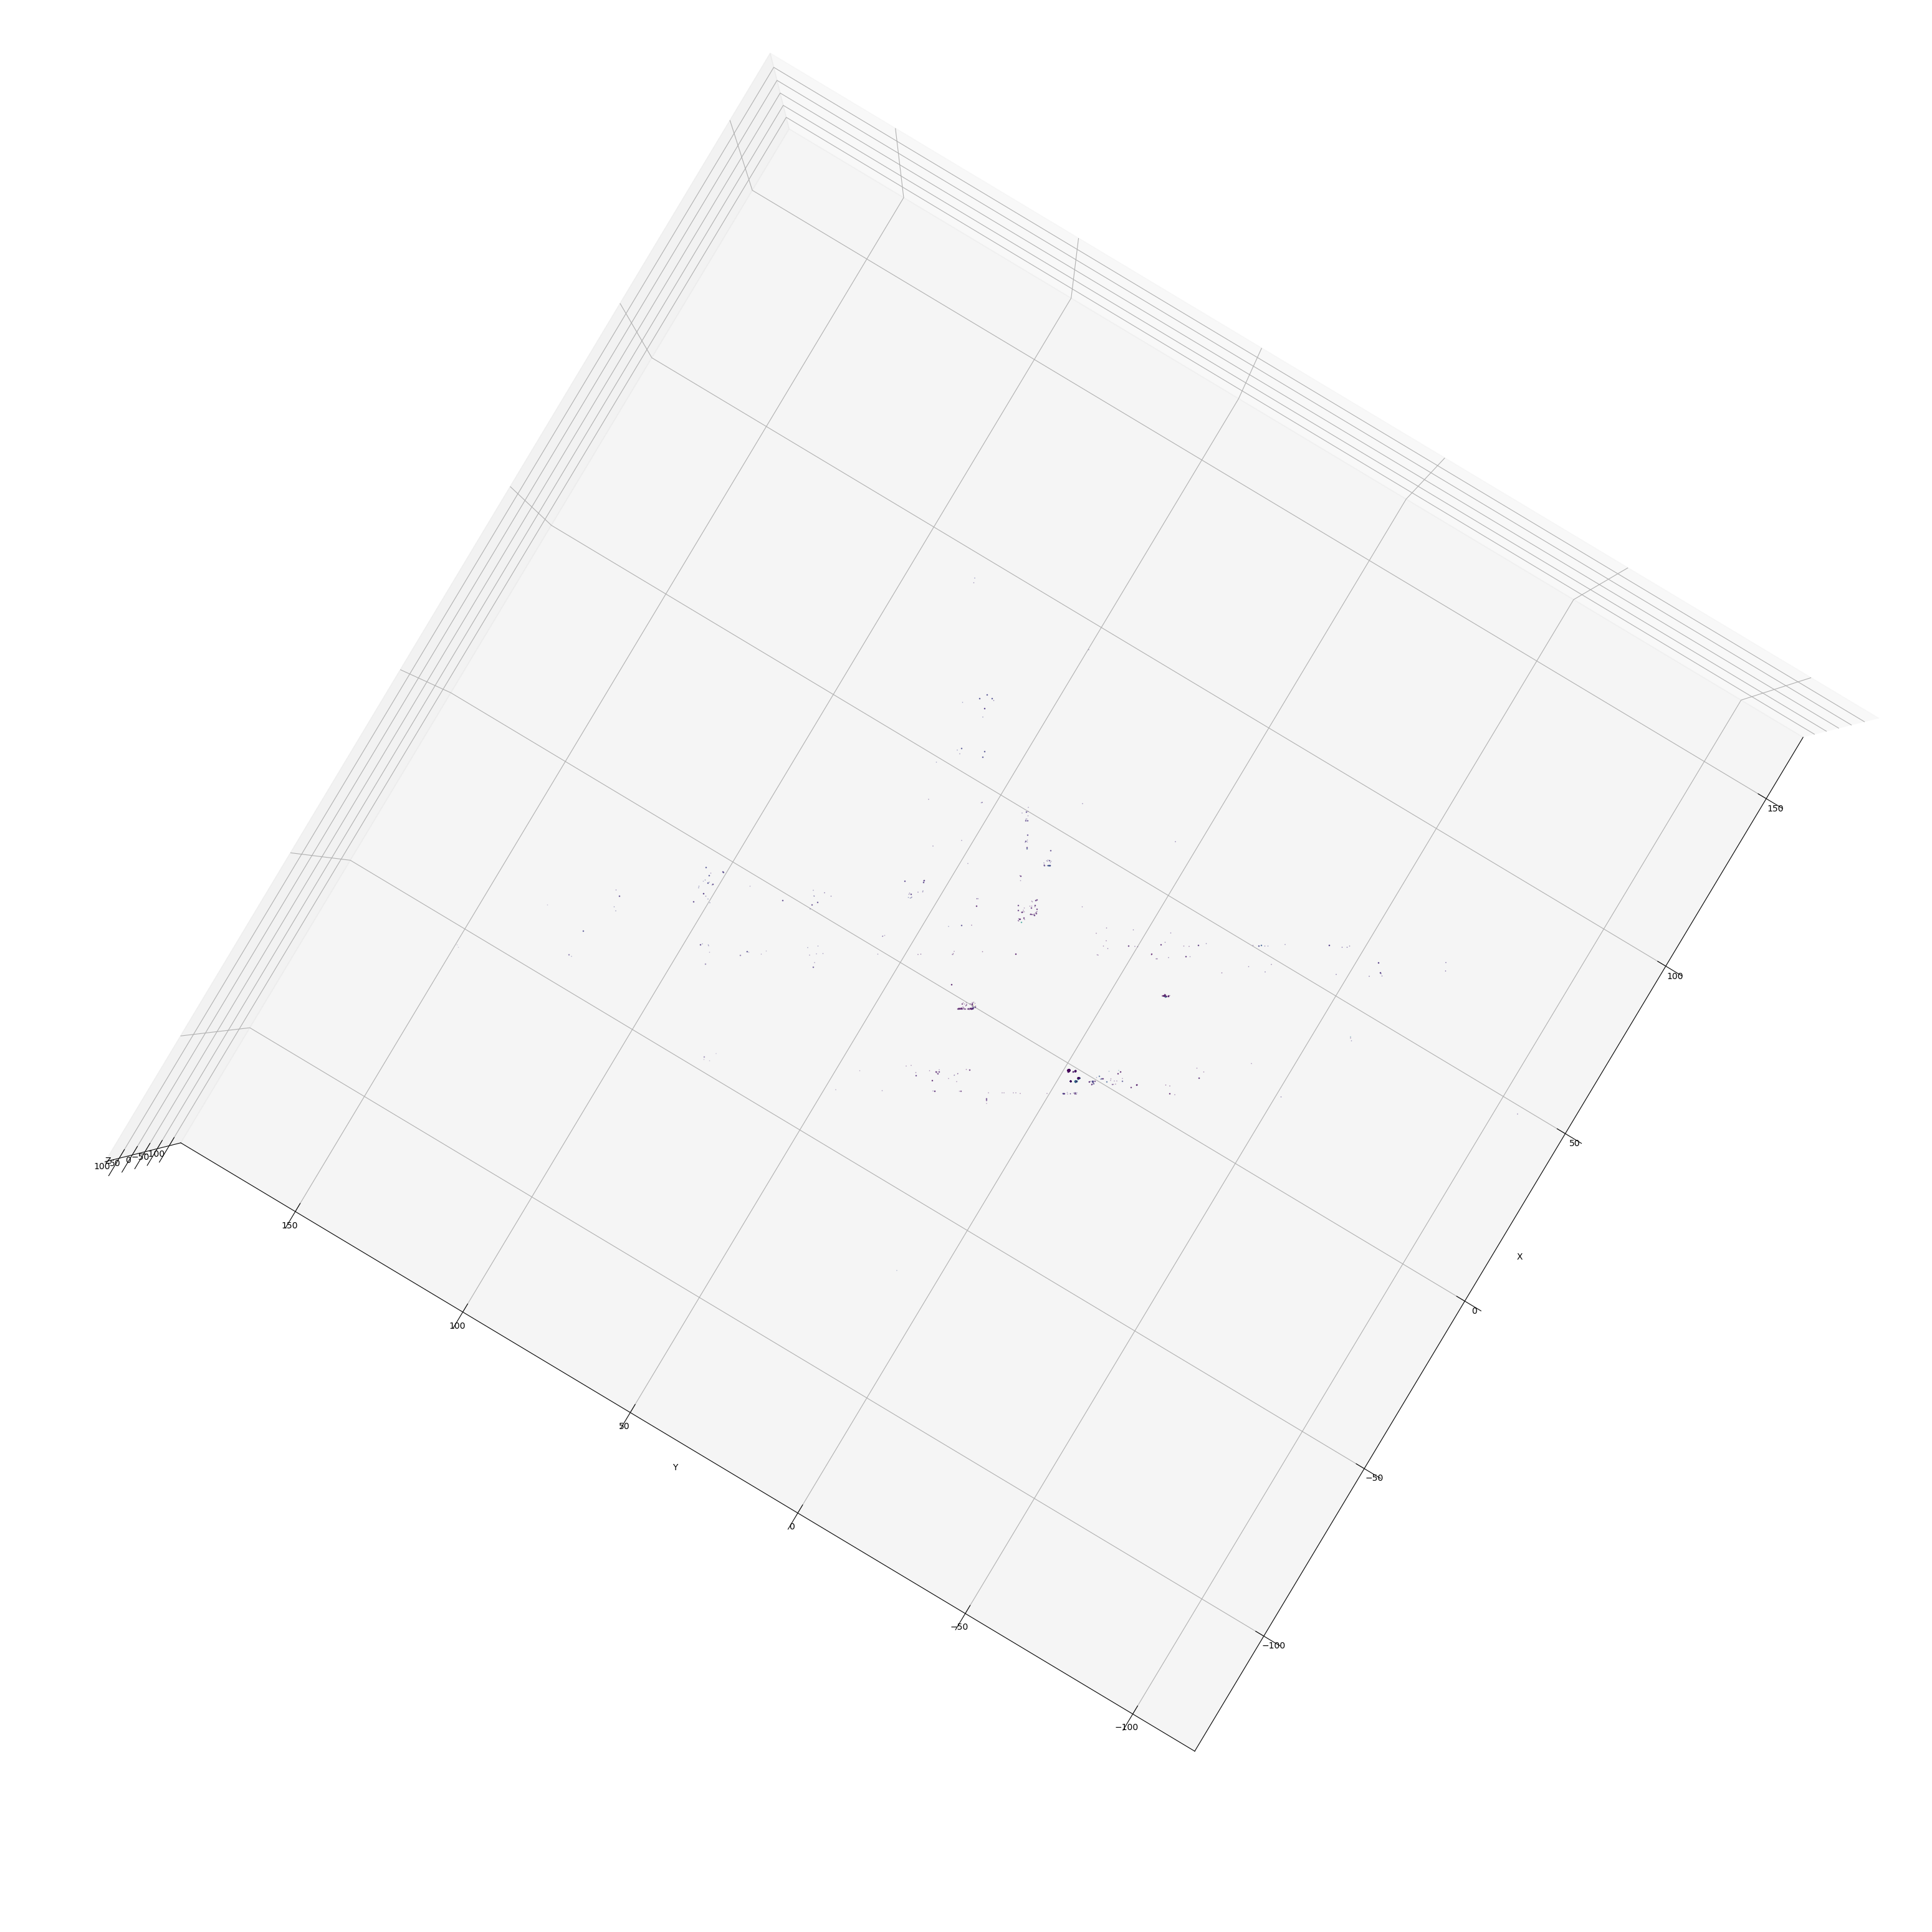

In [38]:
import matplotlib.pyplot as plt
# Set up the plot
fig = plt.figure(figsize=(40, 40))
ax = fig.add_subplot(111, projection='3d')

# Plot the point cloud
ax.scatter(filtered_frame[:, 0], filtered_frame[:, 1], filtered_frame[:, 2], s=0.1, c=filtered_frame[:, 3], cmap='viridis', marker=',')

# Setting the axes properties
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Adjust the view angle if needed
ax.view_init(elev=90, azim=210) # You can change these angles to get a better view

# Fix aspect ratio
set_axes_equal(ax)

plt.show()